
### Electric wave propagation
$$
\begin{align*}
e_t & = d\\
d_t &= - \text{curl curl }e \\
\text{ div } d &= 0
\end{align*}
$$

Since $(e,d)\in H(curl)\times H(div)$ we need to perform an $L_2$-projection
we need to solve at each time step $n$ the following projection: 
$$
\begin{align*}
\hat{e}^n& = e^{n}\\
\hat{d}^n &= \text{curl curl }e^n \\
\text{div }\hat{d}^n& = 0\\
\end{align*}
$$
and:
$$
\begin{align*}
e^{n+1} & = e^{n} -\tau \hat{e}^n \\
d^{n+1}  &= d^{n} -\tau \hat{d}^n \\
\end{align*}
$$

### Numerical implementation:
When we apply the Galerkin discretization we obtain something of the following form:

$$
\begin{align*}
M_{e} \,\hat{\underline e}^n & = M_{ed}\, M_d^{-1} \, \underline d^{n}\\
M_{d} \hat{\underline d}^n &=  M_{de}  M_e^{-1}  \, K \, \underline e^n \\
\text{div }\hat{\underline d}^n& = 0\\
\end{align*}
$$
And to step foreward transforms form:
$$
\begin{align*}
\underline e^{n+1} & = \underline e^{n} -\tau \hat{\underline e}^n \\
\underline d^{n+1}  &= \underline d^{n} -\tau \hat{\underline d}^n \\
\end{align*}
$$

to 

$$
\begin{align*}
\underline e^{n+1} & = \underline e^{n} -\tau M_{e}^{-1} M_{ed}\, M_d^{-1} \,  \underline d^{n} \\
\underline d^{n+1}  &= \underline d^{n} -\tau  M_{d}^{-1}  M_{de}  M_e^{-1}  \, K \, \underline e^n \\
\underline d^{n+1}  &= P \, \underline d^n \\
\end{align*}
$$
Where the last one is the divergence free formjection of $d$.


### We need tobuild the matrix:
$$
\begin{pmatrix}
0 & M_{e}^{-1} M_{ed}\, M_d^{-1}  \\
 M_{d}^{-1}  M_{de}  M_e^{-1} K & 0 
\end{pmatrix}
$$







In [2]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.csg import unit_cube
import matplotlib.pyplot as plt

In [1]:

Maxh = 0.13
Order = 3
mesh = Mesh(unit_cube.GenerateMesh(maxh=Maxh))

fesCurl = HCurl(mesh, order=Order )
fesDiv = HDiv(mesh, order=Order   , dirichlet= ".*")
fesL2 = L2(mesh,  order=Order-1)

fes =  fesCurl*fesDiv
fesP =  fesDiv*fesL2 

peak = exp(-35*( (x-0.5)**2 + (y-0.5)**2 +(z-0.5)**2))
PEAK = CF ( (0, 0, peak ), dims=(3,1))

eps = CF((1), dims=(1,1))
mu =  CF((1), dims=(1,1))

#electric field
elfield = GridFunction(fes) 
e, d = elfield.components
e.Set ( PEAK, bonus_intorder=10, dual=True)

Pelfield = GridFunction(fesP) 
Pd, Pq = Pelfield.components

uc, ud , = fes.TrialFunction()
vc, vd , = fes.TestFunction()


NameError: name 'Mesh' is not defined

In [ ]:
# method

uc,vc = fesCurl.TnT()
edofs = fes.Range(0)
emb_e = Embedding(fes.ndof, edofs)
inv_e = BilinearForm(uc*vc*dx).Assemble().mat.Inverse(inverse="sparsecholesky")
# fesCurl.Mass(Id(mesh.dim)).Inverse()
#inve = emb_e @ inv_e @ emb_e.T


In [2]:

ud,vd = fesDiv.TnT()


ddofs = fes.Range(1)
emb_d = Embedding(fes.ndof, ddofs)
# inv_d = fesDiv.Mass(Id(mesh.dim)).Inverse()
inv_d = BilinearForm(ud*vd*dx).Assemble().mat.Inverse(inverse="sparsecholesky")


#invd = emb_d @ inv_d @ emb_d.T


NameError: name 'fesDiv' is not defined

In [ ]:

#inv = inve + invd


In [ ]:

c = fesCurl.TrialFunction()
v = fesDiv.TestFunction()
M_de = BilinearForm(trialspace=fesCurl, testspace=fesDiv , geom_free = True)
M_de +=  InnerProduct(c, v)*dx
%time M_de.Assemble()
#Med = emb_e @ M_ed.mat @ emb_d.T


CPU times: total: 0 ns
Wall time: 11 ms


In [ ]:
c = fesCurl.TestFunction()
v = fesDiv.TrialFunction()
M_ed = BilinearForm(testspace=fesCurl, trialspace=fesDiv, geom_free = True)
M_ed +=  InnerProduct(c, v)*dx
%time M_ed.Assemble()
#Mde = emb_d @ M_de.mat @ emb_e.T


CPU times: total: 15.6 ms
Wall time: 12 ms


In [ ]:

u = fesCurl.TestFunction()
v = fesCurl.TrialFunction()
K = BilinearForm(fesCurl)
K += -InnerProduct( curl(u), curl(v) )*dx
%time K.Assemble()


CPU times: total: 297 ms
Wall time: 302 ms


In [ ]:
Mup = emb_e @ inv_e @ M_ed.mat @ emb_d.T
Mdown = emb_d @ inv_d @ M_de.mat @ inv_e  @ K.mat @ emb_e.T 

M =  Mdown 


In [ ]:
# We need to define a projection 

u, p  = fesP.TrialFunction()
v, q  = fesP.TestFunction()

P = BilinearForm(fesP)
P +=  v*u * dx
P +=  div( v)*p * dx
P +=  div( u)*q * dx
P += -1e-10*p*q * dx

F = BilinearForm(fesP)
F +=  v*u * dx

P.Assemble()
F.Assemble()

In [ ]:
invP = P.mat.Inverse(inverse="sparsecholesky")

In [ ]:
scene_e = Draw(e, mesh,clipping=(0,0,1))
#scene_divd = Draw(div(d), mesh,clipping=(0,0,1) ,draw_surf=False)
scene_d = Draw(d, mesh,clipping=(0,0,1))
t =  1
tau = 0.002
h = 0
Energy = []
with TaskManager(pajetrace=10**8):
  while h < t :
    h+=tau
    
    #we use only one matrix of the form described in the above markdowm
    elfield.vec.data += tau * Mdown *elfield.vec
    elfield.vec.data += tau * Mup *elfield.vec
    
    #elfield.vec.data += tau* (inv @ Mm ) @ inv * elfield.vec
    scene_d.Redraw()
    # input("stop")
    Pd.vec.data = d.vec
    Pelfield.vec.data =  invP*(F.mat*Pelfield.vec)
    d.vec.data = Pd.vec
    Energy.append(Integrate(InnerProduct(e,e),mesh))
    scene_e.Redraw()
    #print(h)
    #scene_divd.Redraw()
    scene_d.Redraw()
    


WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

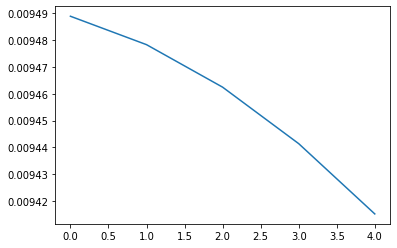

In [ ]:
plt.plot(Energy)

In [ ]:
Mup = emb_e @ inv_e @ M_de.mat @ emb_d.T
Mdown = emb_d @ inv_d @ M_de.mat @ inv_e  @ K.mat @ emb_e.T 

In [ ]:
print(Mup.GetOperatorInfo())
(inv_e @M_de.mat @ emb_d.T*elfield.vec).Evaluate()

: 

: 

In [ ]:
print(Mdown.GetOperatorInfo())

EmbeddedTransposeMatrix, h = 172316, w = 172316
  ProductMatrix, h = 172316, w = 67856
    ProductMatrix, h = 172316, w = 67856
      ProductMatrix, h = 172316, w = 104460
        EmbeddedMatrix, h = 172316, w = 104460
          class ngcomp::ApplyMass, h = 104460, w = 104460
        class ngcomp::BilinearFormApplication, h = 67856, w = 104460
      class ngcomp::ApplyMass, h = 67856, w = 67856
    class ngla::SparseMatrix<double,double,double>, h = 67856, w = 67856



In [ ]:
M_ed.mat.shape


(104460, 67856)

In [ ]:
inv_e.shape


(67856, 67856)